##### <b>Import Python Library</b>

In [1]:
%pip install matplotlib
%pip install seaborn
%matplotlib inline

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


##### <b>Import Data</b>

###### <b>Import SET50 Index</b>

In [2]:
url = 'https://raw.githubusercontent.com/SamapanThongmee/Scrap_SET50_Index_Futures_Data/main/SET50_2006_2023.csv'
SET50 = pd.read_csv(url).iloc[76:,1:]
numerical_columns = SET50.columns[1:]
SET50[numerical_columns] = SET50[numerical_columns].apply(lambda x: x.map(lambda y: pd.to_numeric(str(y).replace(',', ''), errors='coerce')))
SET50 = SET50[['Date','Close']].sort_values(by='Date').drop_duplicates(subset='Date', keep='last').reset_index(drop=True)
SET50['Date']= pd.to_datetime(SET50['Date'])
SET50.head()

,Date,Close
0,2006-04-26,536.63000
1,2006-04-27,533.85999
2,2006-05-02,539.40002
3,2006-05-03,533.78998
4,2006-05-08,547.53003


###### <b>Import SET50 Index Futures</b>

In [3]:
url = 'https://raw.githubusercontent.com/SamapanThongmee/Scrap_SET50_Index_Futures_Data/main/SET50_Index_Futures_Data_2006_2023.csv'
Futures = pd.read_csv(url)
Futures = Futures.pivot(index='Date', columns='Symbol', values='Close').reset_index()
numerical_columns = Futures.columns[1:]
Futures[numerical_columns] = Futures[numerical_columns].apply(lambda x: x.map(lambda y: pd.to_numeric(str(y).replace(',', ''), errors='coerce')))
Futures = Futures.sort_values(by='Date').drop_duplicates(subset='Date', keep='last').reset_index(drop=True)
Futures['Date'] = pd.to_datetime(Futures['Date'])
Futures.head()

Symbol,Date,S50H07,S50H08,S50H09,S50H10,S50H11,S50H12,S50H13,S50H14,S50H15,...,S50Z14,S50Z15,S50Z16,S50Z17,S50Z18,S50Z19,S50Z20,S50Z21,S50Z22,S50Z23
0,2006-04-28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-05-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-05-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-05-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-05-08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
SET50_Futures = SET50.merge(Futures, on='Date', how='inner').reset_index(drop=True)
SET50_Futures = SET50_Futures.rename(columns={'Close':'SET50'})
SET50_Futures.head()

,Date,SET50,S50H07,S50H08,S50H09,S50H10,S50H11,S50H12,S50H13,S50H14,...,S50Z14,S50Z15,S50Z16,S50Z17,S50Z18,S50Z19,S50Z20,S50Z21,S50Z22,S50Z23
0,2006-05-02,539.40002,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-05-03,533.78998,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-05-08,547.53003,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-05-09,546.14001,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-05-10,544.67999,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### <b>SET50 Index Contango and Backwardation: Statistics</b>

In [5]:
def calculate_statistics(lst, series_name):
    lst_without_null = pd.Series(lst).dropna()
    percentiles = [0.1, 2.3, 15.9, 50, 84.1, 97.7, 99.9]

    stats = [series_name,
             lst_without_null.min(),
             lst_without_null.max(),
             lst_without_null.median(),
             lst_without_null.mean(),
             lst_without_null.std(),
             len(lst_without_null)]

    if not lst_without_null.empty:
        percentiles_values = np.percentile(lst_without_null, percentiles)
        stats.extend(percentiles_values)
    else:
        stats.extend([np.nan] * len(percentiles))

    return stats

# Extract series names
series_names = ['H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
                'M06', 'M07', 'M08', 'M09', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M19', 'M20', 'M21', 'M22', 'M23',
                'U06', 'U07', 'U08', 'U09', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16', 'U17', 'U18', 'U19', 'U20', 'U21', 'U22', 'U23',
                'Z06', 'Z07', 'Z08', 'Z09', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14', 'Z15', 'Z16', 'Z17', 'Z18', 'Z19', 'Z20', 'Z21', 'Z22', 'Z23']

# Extract series data
series_data = [SET50_Futures[['Date', 'SET50', f'S50{series}']].dropna().reset_index(drop=True) for series in series_names]

# Calculate differences and store in a dictionary
diff_dict = {}
for series_name, series_df in zip(series_names, series_data):
    series_df['Diff'] = series_df['SET50'] - series_df[f'S50{series_name}']
    diff_dict[f'SET50_{series_name}'] = list(series_df['Diff'])

# Calculate statistics
data = []
for series_name, lst in diff_dict.items():
    filtered_lst = [value for value in lst if -100 <= value <= 100]
    stats = calculate_statistics(filtered_lst, series_name)
    data.append(stats)

# Create DataFrame
columns = ['Series', 'min', 'max', 'median', 'mean', 'sd', 'count', '0.1%', '2.3%', '15.9%', '50%', '84.1%', '97.7%', '99.9%']
df = pd.DataFrame(data, columns=columns)
df = df[['Series', 'min', '0.1%', '2.3%', '15.9%', 'median', '84.1%', '97.7%', '99.9%', 'max', 'mean', 'sd', 'count']]
SET50_Futures = df
SET50_Futures

,Series,min,0.1%,2.3%,15.9%,median,84.1%,97.7%,99.9%,max,mean,sd,count
0,SET50_H07,-30.04001,-27.730157,-9.647508,-6.616299,-1.675005,3.694900,8.420901,14.759351,15.19000,-1.464117,5.472129,136
1,SET50_H08,-15.50001,-15.434762,-12.131263,-6.281268,0.054995,5.237974,12.094737,18.260998,18.63000,-0.364512,5.798732,226
2,SET50_H09,-11.17999,-10.315887,-6.031978,0.453900,4.769980,8.638890,12.700081,17.573468,18.00000,4.544279,4.589235,222
3,SET50_H10,-4.09003,-3.983098,-2.161410,1.178214,4.880000,9.519037,15.334530,26.428602,28.81000,5.434877,4.554643,244
4,SET50_H11,-6.01001,-5.983612,-4.814805,-0.619995,4.670000,9.418790,12.585604,14.448780,14.47998,4.408550,4.712138,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,SET50_Z19,-3.37000,-3.248000,-1.763880,1.193700,4.730000,13.608560,17.715520,19.662160,19.75000,6.241308,5.596770,245
67,SET50_Z20,-7.68999,-6.878377,-1.823304,1.378217,7.934995,15.580007,19.390521,25.592310,25.75997,8.304426,6.261430,244
68,SET50_Z21,-1.07000,-0.961543,-0.260560,1.855540,6.400005,9.708107,14.289396,15.912792,15.92002,6.248843,3.794983,242
69,SET50_Z22,-3.95997,-3.747892,-2.422855,0.805957,8.840010,13.866803,18.631670,20.272020,20.46000,8.031281,5.881461,242


###### <b>SET50 Index Contango: Sort by median</b>

In [6]:
SET50_Futures_Contango = SET50_Futures.sort_values(by='median', ascending=True).head(10).reset_index(drop=True)
SET50_Futures_Contango

,Series,min,0.1%,2.3%,15.9%,median,84.1%,97.7%,99.9%,max,mean,sd,count
0,SET50_Z06,-22.10999,-21.818723,-16.266460,-6.918539,-3.035010,5.152391,11.485279,17.601510,18.20001,-2.241119,6.910514,134
1,SET50_H07,-30.04001,-27.730157,-9.647508,-6.616299,-1.675005,3.694900,8.420901,14.759351,15.19000,-1.464117,5.472129,136
2,SET50_M07,-32.94001,-29.589696,-9.773912,-6.006637,-1.465000,3.253152,5.783487,9.617768,10.13000,-1.646868,4.809364,182
3,SET50_Z07,-13.50001,-13.364048,-10.334573,-5.517215,-1.179990,4.304445,12.899807,15.269896,15.40997,-0.768937,5.412229,207
4,SET50_M06,-14.14000,-14.112100,-13.498293,-9.779402,-1.070000,6.760021,11.176700,11.552900,11.57000,-0.839032,7.566645,31
5,SET50_H08,-15.50001,-15.434762,-12.131263,-6.281268,0.054995,5.237974,12.094737,18.260998,18.63000,-0.364512,5.798732,226
6,SET50_M08,-25.99999,-22.890137,-10.786530,-6.224956,0.109970,5.291470,11.851835,18.965435,19.63000,-0.259360,5.896636,235
7,SET50_U07,-42.04001,-35.546250,-9.009914,-4.178551,0.299990,5.422071,13.807030,17.105224,17.23003,0.348613,5.874337,209
8,SET50_U06,-19.10999,-18.768752,-13.490523,-5.799919,0.859990,9.179089,13.199643,17.788410,18.10001,1.332857,7.568975,77
9,SET50_U08,-15.37000,-14.954633,-10.825873,-4.964710,1.390010,6.118560,10.006450,14.287943,14.59003,0.773124,5.571817,237


###### <b>SET50 Index Backwardation: Sort by median</b>

In [7]:
SET50_Futures_Backwardation = SET50_Futures.sort_values(by='median', ascending=False).head(10).reset_index(drop=True)
SET50_Futures_Backwardation

,Series,min,0.1%,2.3%,15.9%,median,84.1%,97.7%,99.9%,max,mean,sd,count
0,SET50_M16,-5.02998,-4.532630,-2.390934,3.049670,23.70000,31.192700,35.138409,37.574528,37.91998,19.930528,11.848964,246
1,SET50_U16,-3.09003,-3.019265,-0.117012,5.423884,18.66001,37.381586,42.929228,44.884822,45.08002,20.507429,13.978628,245
2,SET50_H16,-6.14001,-5.160005,-0.414605,7.625501,15.15499,24.093179,28.696593,32.270528,32.41998,15.401056,7.694794,246
3,SET50_U15,-1.96002,-1.789918,1.450680,7.335484,12.32000,17.200820,22.912326,25.424110,25.48000,12.311927,5.272642,244
4,SET50_U17,-5.74000,-5.661600,-1.811900,3.735151,11.93000,18.913149,22.991898,24.915900,24.95999,10.495244,7.183415,246
5,SET50_U20,-2.16998,-1.772272,0.410594,4.311830,11.50000,15.492040,18.371760,23.916020,24.05997,10.366449,5.270705,245
6,SET50_Z15,-5.31997,-4.454895,-0.815760,2.869103,11.34001,17.437260,22.732614,27.943707,28.41998,10.764550,6.747456,244
7,SET50_Z16,-16.82998,-13.611627,-2.821158,0.603852,10.13000,40.937876,49.991044,51.315860,51.35002,14.826369,16.430380,245
8,SET50_U22,-1.17002,-0.855415,1.448460,6.018619,9.90002,14.291320,18.077371,19.568040,19.66000,9.909547,4.066813,243
9,SET50_U14,-3.61990,-3.375900,0.606760,4.353480,9.86990,15.973014,22.108636,29.218620,30.78998,10.214491,5.765491,245


###### <b>SET50 Index Contango and Backwardation: Visualization</b>

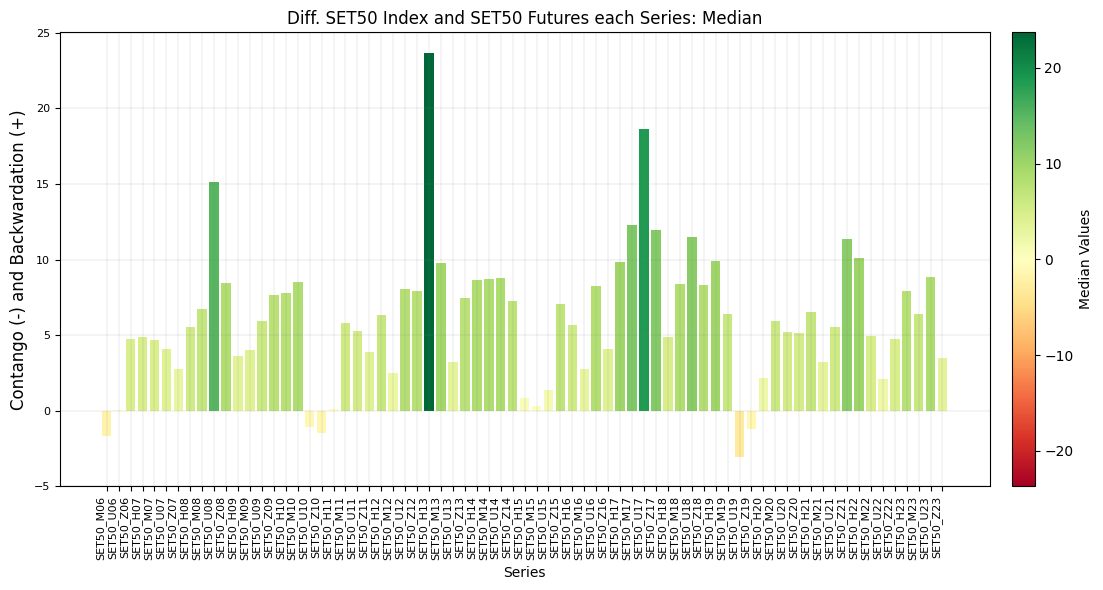

In [8]:
SET50_Futures_Plot = SET50_Futures[['Series', 'median']]

series = SET50_Futures_Plot['Series']
median_values = SET50_Futures_Plot['median']

custom_order = [
    'SET50_M06', 'SET50_U06', 'SET50_Z06',
    'SET50_H07', 'SET50_M07', 'SET50_U07', 'SET50_Z07',
    'SET50_H08', 'SET50_M08', 'SET50_U08', 'SET50_Z08',
    'SET50_H09', 'SET50_M09', 'SET50_U09', 'SET50_Z09',
    'SET50_H10', 'SET50_M10', 'SET50_U10', 'SET50_Z10',
    'SET50_H11', 'SET50_M11', 'SET50_U11', 'SET50_Z11',
    'SET50_H12', 'SET50_M12', 'SET50_U12', 'SET50_Z12',
    'SET50_H13', 'SET50_M13', 'SET50_U13', 'SET50_Z13',
    'SET50_H14', 'SET50_M14', 'SET50_U14', 'SET50_Z14',
    'SET50_H15', 'SET50_M15', 'SET50_U15', 'SET50_Z15',
    'SET50_H16', 'SET50_M16', 'SET50_U16', 'SET50_Z16',
    'SET50_H17', 'SET50_M17', 'SET50_U17', 'SET50_Z17',
    'SET50_H18', 'SET50_M18', 'SET50_U18', 'SET50_Z18',
    'SET50_H19', 'SET50_M19', 'SET50_U19', 'SET50_Z19',
    'SET50_H20', 'SET50_M20', 'SET50_U20', 'SET50_Z20',
    'SET50_H21', 'SET50_M21', 'SET50_U21', 'SET50_Z21',
    'SET50_H22', 'SET50_M22', 'SET50_U22', 'SET50_Z22',
    'SET50_H23', 'SET50_M23', 'SET50_U23', 'SET50_Z23'
]

SET50_Futures_Plot['Custom_Order'] = SET50_Futures_Plot['Series'].astype(
    pd.CategoricalDtype(categories=custom_order, ordered=True)
)

SET50_Futures_Plot_sorted = SET50_Futures_Plot.sort_values(by='Custom_Order')
SET50_Futures_Plot_sorted = SET50_Futures_Plot_sorted.drop('Custom_Order', axis=1)

norm = mcolors.Normalize(vmin=-max(abs(median_values)), vmax=max(abs(median_values)))
colors = plt.cm.RdYlGn(norm(median_values))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(SET50_Futures_Plot_sorted['Series'], median_values, color=colors)
ax.set_xlabel('Series', fontsize=10)
ax.set_ylabel('Contango (-) and Backwardation (+)', fontsize=12)
ax.set_title('Diff. SET50 Index and SET50 Futures each Series: Median')

ax.set_yticks(np.arange(-5, 26, 5))
ax.tick_params(axis='both', which='major', labelsize=8)

sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Median Values')

# Customize x-axis labels
ax.set_xticks(range(len(SET50_Futures_Plot_sorted['Series'])))
ax.set_xticklabels(SET50_Futures_Plot_sorted['Series'], rotation=90, ha='right', fontsize=8)

# Add grid lines with grey50 color and 0.4 opacity
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()